## Importação dos pacotes

In [48]:
# importar pacotes necessários
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Carga dos dados de entrada

In [96]:
# carregar arquivo de dados de treino
filename = 'abalone-train.csv'
#filename = 'https://github.com/hjort/ai-labs/raw/master/kaggle/serpro-abalone/abalone-train.csv'
data = pd.read_csv(filename, index_col='id')

# mostrar alguns exemplos de registros
data.head()

,sex,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,rings
id,,,,,,,,,
2758,M,0.535,0.430,0.155,0.7845,0.3285,0.1690,0.2450,10
1384,F,0.630,0.485,0.170,1.3205,0.5945,0.3450,0.3450,9
1131,M,0.565,0.435,0.150,0.9900,0.5795,0.1825,0.2060,8
3726,I,0.500,0.395,0.145,0.7865,0.3320,0.1815,0.2455,8
3445,I,0.495,0.400,0.145,0.5780,0.2545,0.1305,0.1645,8


In [50]:
cols = ['length', 'diameter', 'height', 'whole_weight',
       'shucked_weight', 'viscera_weight', 'shell_weight']

## Métodos de detecção de outliers

### 1. via gráficos de dispersão

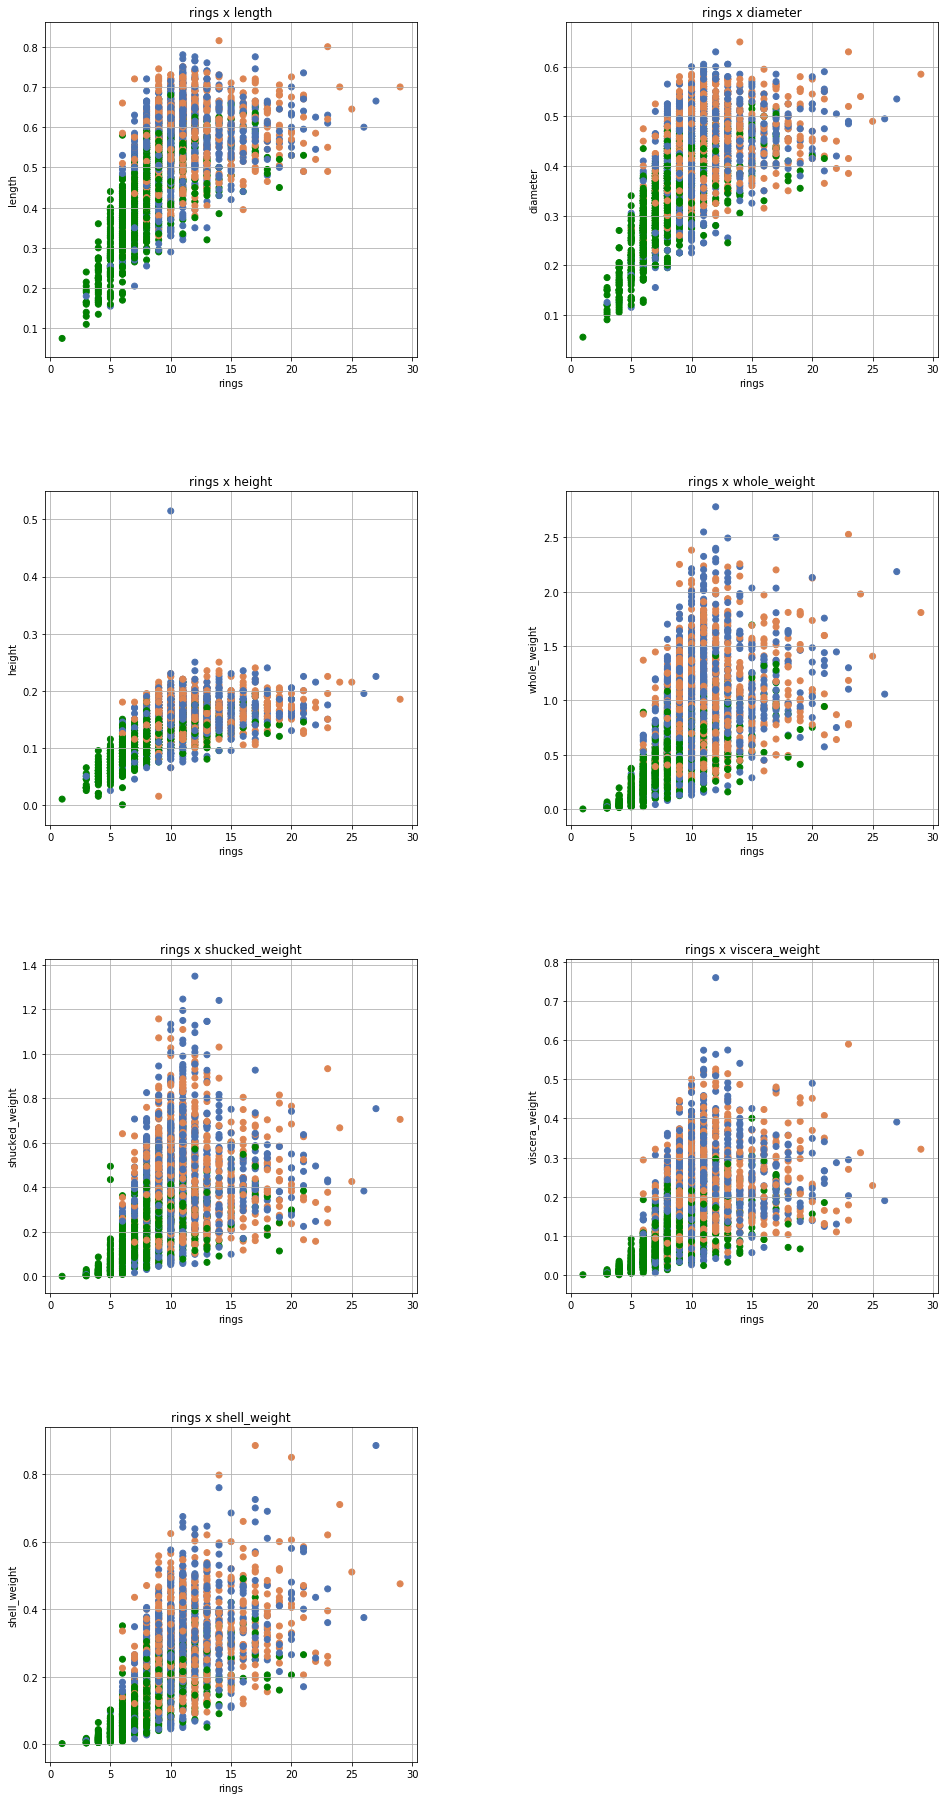

In [55]:
colors = {'M': '#4c72b0', 'F': '#dd8452', 'I': 'green'}

# parâmetros
rows_count = 4
cols_count = 2
col_x = 'rings'

plt.figure(figsize=(16, 32))

i = 0
for col_y in cols:
    plt.subplot(rows_count, cols_count, (i + 1))
    plt.scatter(data[col_x], data[col_y], c=data['sex'].map(colors))
    plt.subplots_adjust(hspace=0.4, wspace=0.4)
    plt.xlabel(col_x)
    plt.ylabel(col_y)
    plt.title(col_x + ' x ' + col_y)
    plt.grid()
    i += 1

plt.show()

In [97]:
outliers = np.concatenate((
    data[(data['length'] < 0.1) | (data['length'] > 0.8)].index,
    data[(data['length'] < 0.8) & (data['rings'] > 23)].index,
    data[(data['diameter'] < 0.06) | (data['diameter'] > 0.625)].index,
    data[(data['diameter'] < 0.7) & (data['rings'] > 23)].index,
    data[(data['height'] < 0.0125) | (data['height'] > 0.3)].index,
    data[(data['height'] < 0.5) & (data['rings'] > 24)].index,
    data[(data['whole_weight'] < 0.01) | (data['whole_weight'] > 2.5)].index,
    data[(data['whole_weight'] < 2.5) & (data['rings'] > 24)].index,
    data[(data['shucked_weight'] < 0.005) | (data['shucked_weight'] > 1.15)].index,
    data[(data['shucked_weight'] < 1.5) & (data['rings'] > 24)].index,
    data[(data['viscera_weight'] < 0.002) | (data['viscera_weight'] > 0.58)].index,
    data[(data['viscera_weight'] < 0.8) & (data['rings'] > 24)].index,
    data[(data['shell_weight'] < 0.004) | (data['shell_weight'] > 0.85)].index,
    data[(data['shell_weight'] < 0.9) & (data['rings'] > 24)].index,
), axis=0)
outliers[:10]

array([ 236, 1428, 3149, 2201,  294,  480, 2108,  236, 1763, 2334],
      dtype=int64)

In [98]:
data['outlier1'] = data.index.map(lambda idx: 1 if idx in outliers else 0)

### 2. via Z-Score

- https://medium.com/datadriveninvestor/finding-outliers-in-dataset-using-python-efc3fce6ce32

In [6]:
threshold = 3

for col in cols:
#col = 'length'
#if True:
    
    z_col = 'z_' + col
    o_col = 'o_' + col

    col_mean = data[col].mean()
    col_stddev = data[col].std()
    #print('Column:  %s\nMean:    %.2f\nStd Dev: %.4f\n' % (col, col_mean, col_stddev))

    data[z_col] = (data[col] - col_mean) / col_stddev
    data[o_col] = data[z_col].apply(lambda z: 1 if np.abs(z) > threshold else 0)

In [7]:
data['outlier2'] = data['o_length'] + data['o_diameter'] + data['o_height'] + \
                    data['o_whole_weight'] + data['o_shucked_weight'] + \
                    data['o_viscera_weight'] + data['o_shell_weight']

# considerar apenas a variável 'height'
data['outlier2'] = data['o_height']

data.outlier2 = data.outlier2.astype('category')

#data[data.outlier2 != 0]

### 3. via IQR

- https://medium.com/datadriveninvestor/finding-outliers-in-dataset-using-python-efc3fce6ce32

In [8]:
iqr_factor = 1.5

for col in cols:
#col = 'length'
#if True:

    o_col = 'o_' + col

    col_q1 = data[col].quantile(0.25)
    col_q3 = data[col].quantile(0.75)
    col_iqr = col_q3 - col_q1
    col_lower = col_q1 - (1.5 * col_iqr)
    col_upper = col_q3 + (1.5 * col_iqr)
    
    #print('Column: %s\nQ1:     %.2f\nQ3:     %.4f\nIQR:    %.4f\nLower:  %.4f\nUpper:  %.4f\n' % \
    #      (col, col_q1, col_q3, col_iqr, col_lower, col_upper))

    data[o_col] = data[col].apply(lambda x: 1 if (x < col_lower or x > col_upper) else 0)

In [9]:
data['outlier3'] = data['o_length'] + data['o_diameter'] + data['o_height'] + \
                    data['o_whole_weight'] + data['o_shucked_weight'] + \
                    data['o_viscera_weight'] + data['o_shell_weight']

# considerar apenas a variável 'height'
data['outlier3'] = data['o_height']

data.outlier3 = data.outlier3.astype('category')

#data[data.outlier3 != 0]

### 4-10. via PyOD

- https://pyod.readthedocs.io/en/latest/
- https://www.analyticsvidhya.com/blog/2019/02/outlier-detection-python-pyod/

In [10]:
from pyod.models.abod import ABOD
from pyod.models.cblof import CBLOF
from pyod.models.feature_bagging import FeatureBagging
from pyod.models.hbos import HBOS
from pyod.models.iforest import IForest
from pyod.models.knn import KNN
from pyod.models.lof import LOF

In [28]:
outliers_fraction = 0.005 # percentual de contaminação
sufixo_arquivo = '%.2f' % (outliers_fraction * 100)

random_state = np.random.RandomState(42)

# modelos a serem usados na detecção de anomalias
classifiers = {
    'Angle-based Outlier Detector (ABOD)': ABOD(contamination=outliers_fraction),
    'Cluster-based Local Outlier Factor (CBLOF)': CBLOF(contamination=outliers_fraction,
                                                        check_estimator=False, random_state=random_state),
    'Feature Bagging': FeatureBagging(LOF(n_neighbors=35), contamination=outliers_fraction,
                       check_estimator=False, random_state=random_state),
    'Histogram-base Outlier Detection (HBOS)': HBOS(contamination=outliers_fraction),
    'Isolation Forest': IForest(contamination=outliers_fraction, random_state=random_state),
    'K Nearest Neighbors (KNN)': KNN(contamination=outliers_fraction),
    'Average KNN': KNN(method='mean', contamination=outliers_fraction)
}

In [38]:
# seleção dos dados a serem usados na detecção
#X = data[cols]
X = data[['length', 'height']]
#X = data[['length', 'height', 'whole_weight', 'rings']]
#X.info()

In [39]:
outlier_start = 4
for i, (clf_name, clf) in enumerate(classifiers.items()):
    print(i + 1, clf)
    clf.fit(X)
    col = 'outlier' + str(i + outlier_start)
    data[col] = clf.labels_
    data[col] = data[col].astype('category')

1 ABOD(contamination=0.005, method='fast', n_neighbors=5)


/opt/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3157: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/opt/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/opt/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3652: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/opt/anaconda3/lib/python3.6/site-packages/pyod/models/base.py:360: RuntimeWarning: invalid value encountered in greater
  self.labels_ = (self.decision_scores_ > self.threshold_).astype(


2 CBLOF(alpha=0.9, beta=5, check_estimator=False, clustering_estimator=None,
   contamination=0.005, n_clusters=8, n_jobs=1,
   random_state=<mtrand.RandomState object at 0x9c812f04>,
   use_weights=False)
3 FeatureBagging(base_estimator=LOF(algorithm='auto', contamination=0.1, leaf_size=30, metric='minkowski',
  metric_params=None, n_jobs=1, n_neighbors=35, p=2),
        bootstrap_features=False, check_detector=True,
        check_estimator=False, combination='average', contamination=0.005,
        estimator_params={}, max_features=1.0, n_estimators=10, n_jobs=1,
        random_state=<mtrand.RandomState object at 0x9c812f04>, verbose=0)
4 HBOS(alpha=0.1, contamination=0.005, n_bins=10, tol=0.5)
5 IForest(behaviour='old', bootstrap=False, contamination=0.005,
    max_features=1.0, max_samples='auto', n_estimators=100, n_jobs=1,
    random_state=<mtrand.RandomState object at 0x9c812f04>, verbose=0)


/opt/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)


6 KNN(algorithm='auto', contamination=0.005, leaf_size=30, method='largest',
  metric='minkowski', metric_params=None, n_jobs=1, n_neighbors=5, p=2,
  radius=1.0)
7 KNN(algorithm='auto', contamination=0.005, leaf_size=30, method='mean',
  metric='minkowski', metric_params=None, n_jobs=1, n_neighbors=5, p=2,
  radius=1.0)


## Visualização de gráficos

/opt/anaconda3/lib/python3.6/site-packages/seaborn/axisgrid.py:2065: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)


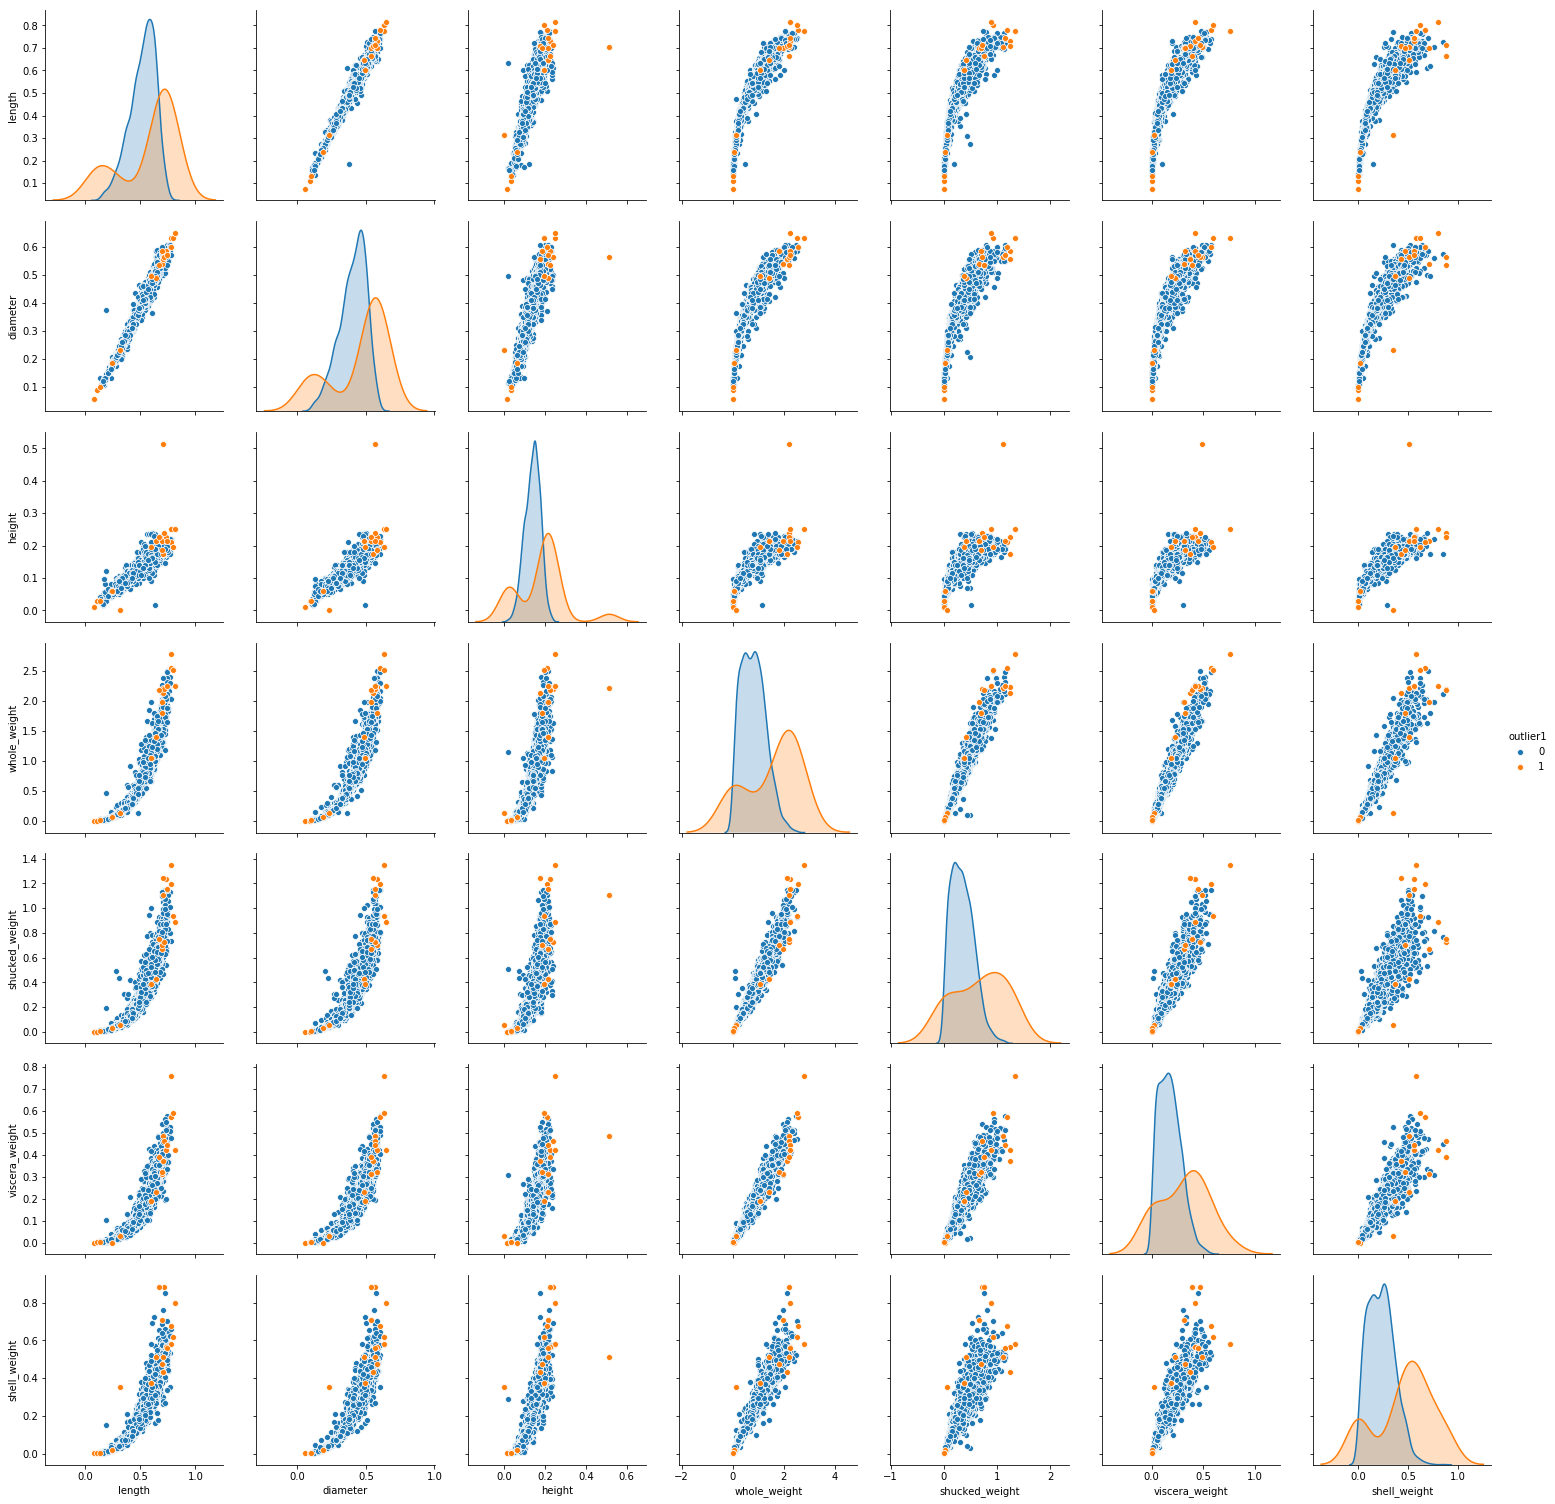

In [99]:
# gerar gráfico em pares com kde nas diagonais
sns.pairplot(data, hue="outlier1", size=3, diag_kind="kde", vars=cols)

/opt/anaconda3/lib/python3.6/site-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


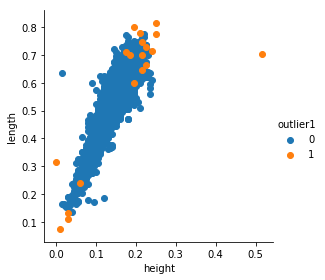

In [100]:
sns.FacetGrid(data, hue="outlier1", size=4) \
   .map(plt.scatter, "height", "length") \
   .add_legend()

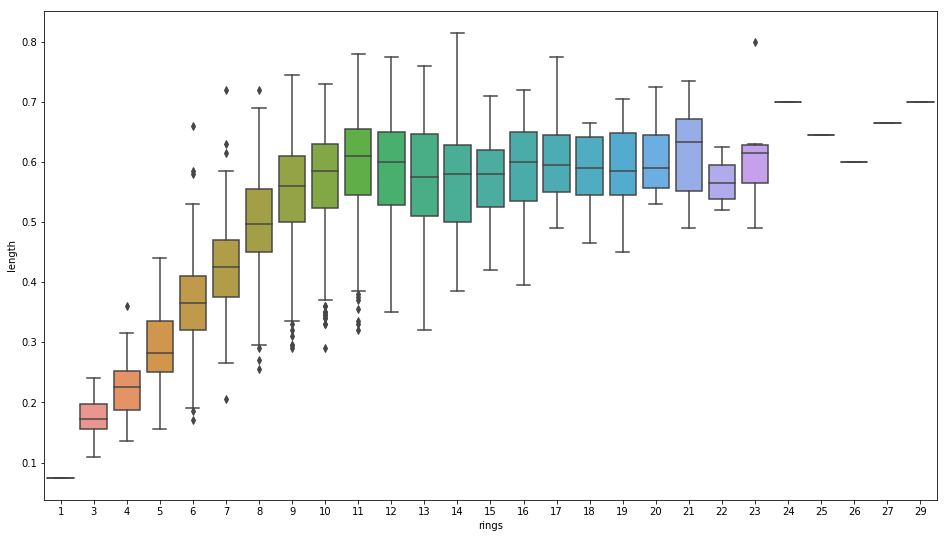

In [17]:
# gerar um gráfico do tipo boxplot sobre uma característica individual
plt.figure(figsize=(16, 9))
sns.boxplot(x="rings", y="length", data=data)

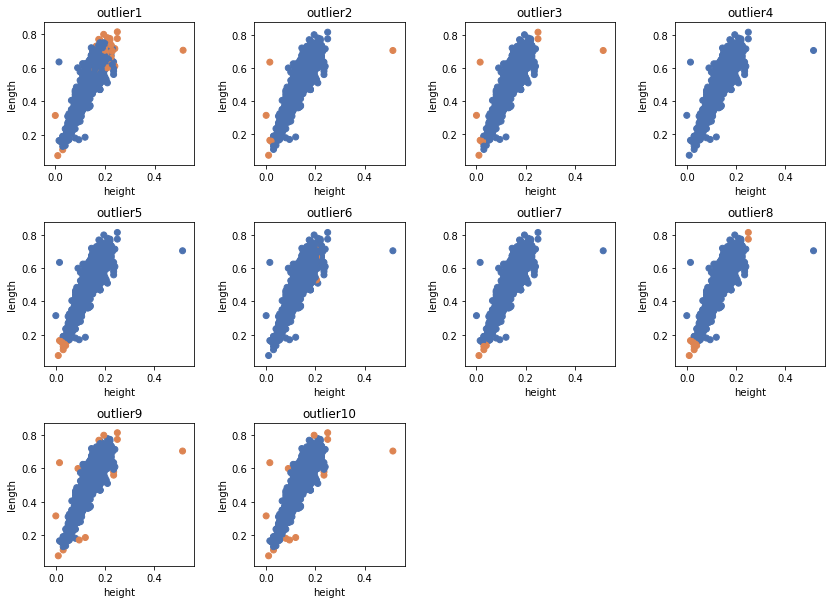

In [41]:
colors = {0: '#4c72b0', 1: '#dd8452'}

# parâmetros
outlier_start = 1
outlier_count = 10
rows_count = 3
cols_count = 4
col_x = 'height'
col_y = 'length'

plt.figure(figsize=(14, 10))

for i in range(outlier_count):
    col = 'outlier' + str(i + outlier_start)
    plt.subplot(rows_count, cols_count, (i + 1))
    plt.scatter(data[col_x], data[col_y], c=data[col].map(colors))
    plt.subplots_adjust(hspace=0.4, wspace=0.4)
    plt.xlabel(col_x)
    plt.ylabel(col_y)
    plt.title(col)

plt.show()

## Remoção das anomalias

In [101]:
# gerar arquivos CSV sem as anomalias
outlier_start = 1
outlier_count = 10

pcols = cols + ['sex', 'rings']
for i in range(outlier_start, outlier_count - outlier_start + 1 + 1):
    col = 'outlier' + str(i)
    filename = 'abalone-train-o' + str(i) + '-' + sufixo_arquivo + '.csv'
    print('Gerando arquivo:', filename)
    data[data[col] == 0][pcols].to_csv(filename)

Gerando arquivo: abalone-train-o1-0.50.csv


In [44]:
!wc -l  abalone-train-o*.csv

   2673 abalone-train-o1-0.50.csv
   2673 abalone-train-o1-1.00.csv
   2673 abalone-train-o1-10.00.csv
   2673 abalone-train-o1-5.00.csv
   2673 abalone-train-o1-7.50.csv
   2673 abalone-train-o1.csv
   2771 abalone-train-o10-0.50.csv
   2757 abalone-train-o10-1.00.csv
   2506 abalone-train-o10-10.00.csv
   2645 abalone-train-o10-5.00.csv
   2576 abalone-train-o10-7.50.csv
   2764 abalone-train-o10.csv
   2778 abalone-train-o2-0.50.csv
   2778 abalone-train-o2-1.00.csv
   2778 abalone-train-o2-10.00.csv
   2778 abalone-train-o2-5.00.csv
   2778 abalone-train-o2-7.50.csv
   2778 abalone-train-o2.csv
   2774 abalone-train-o3-0.50.csv
   2774 abalone-train-o3-1.00.csv
   2774 abalone-train-o3-10.00.csv
   2774 abalone-train-o3-5.00.csv
   2774 abalone-train-o3-7.50.csv
   2774 abalone-train-o3.csv
   2785 abalone-train-o4-0.50.csv
   2757 abalone-train-o4-1.00.csv
   2506 abalone-train-o4-10.00.csv
   2645 abalone-train-o4-5.00.csv
   2576 abalone-train-o4-7.50.csv
   2764 abalone-train-o